In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import sys

sys.path.append(r"C:\Users\giusy\OneDrive\Desktop\PAPERS\2026_Sensors_speech\SilentWear")
from utils.I_data_preparation.experimental_config import label_to_word_map, FS
from utils.II_feature_extraction.feature_extractor import *

In [3]:
feature_extractor = FeatureExtractor(fs=FS)

In [5]:
DATA_DIRECTORY = Path(r"C:\Users\giusy\OneDrive\Desktop\PAPERS\2026_Sensors_speech\SilentWear\data")
SUB_ID = 'S01'


data_dire_raw = DATA_DIRECTORY/'raw'/SUB_ID
data_dire_processed = DATA_DIRECTORY/'processed'/SUB_ID
data_dire_silent = data_dire_processed/'silent'
data_dire_vocalized = data_dire_processed/'vocalized'

WINDOW_SIZE_S = 1.4

# This parameter is used when we perform "Manual" Feature extraction
# In this case, the "big window" is divided into smaller-windows
NUM_SUBWINDOWS = 7


In [ ]:
def add_metadata(
    self, feature_row: dict, trigger_value: int, mat_file: Path
    ) -> dict:
    """Add labels and metadata to feature row.

    Args:
        feature_row: Feature dictionary to update.
        trigger_value: Trigger value at word start.
        mat_file: Path to mat file.

    Returns:
        Updated feature dictionary.
    """
    feature_row["word_label"] = TriggerWordMapper.get_word_by_trigger_val(
        trigger_value
    )

    batch, session = FilePathParser.extract_session_batch_from_path(
        mat_file.parent, mat_file.stem
    )
    feature_row["batch"] = batch
    feature_row["session"] = session

    return feature_row


In [7]:
def find_word_segments_df(df: pd.DataFrame, 
                          valid_vals: set[int], 
                          label_col="Label_str"):
    s = df[label_col]
    run_id = (s != s.shift(1)).cumsum()

    seg = (
        df.assign(_run=run_id)
          .groupby("_run", sort=False)
          .agg(
              start_idx=(label_col, lambda x: int(x.index[0])),
              end_idx  =(label_col, lambda x: int(x.index[-1]) + 1),
              label_int=(label_col, "first"),
              label_str=("Label_str", "first") if "Label_str" in df.columns else (label_col, "first"),
              run_len  =(label_col, "size"),
          )
          .reset_index(drop=True)
    )

    return seg[seg["label_int"].isin(valid_vals)].reset_index(drop=True)


In [26]:

def extract_channel_features(
    df_filtered: pd.DataFrame,
    start_idx: int,
    channel_tag: str,
    sample_per_big_window: int,
    sample_per_small_window: int,
)    -> Dict[str, float]:
    """Extract features for a SINGLE channel across all small windows.

    Args:
        emg_filtered: Filtered EMG data (samples x channels).
        start_idx: Starting sample index for the big window.
        channel_ind: Channel index in the data array.
        channel_tag: Channel name tag (e.g., '01n').
        sample_per_big_window: Number of samples in big window.
        sample_per_small_window: Number of samples in small window.

    Returns:
        Dictionary with all features for this channel, keyed by feature name.
    """
    num_small_windows = sample_per_big_window // sample_per_small_window
    feature_row = {}

    for small_index in range(num_small_windows):
        small_start = start_idx + small_index * sample_per_small_window
        small_end = small_start + sample_per_small_window
        small_window_data = df_filtered.loc[small_start:small_end, channel_tag].values

        window_features = feature_extractor.extract_window_features(small_window_data)
        window_num = small_index + 1

        for feature_name, feature_value in window_features.items():
            feature_name = feature_extractor._build_feature_name(
                feature_name, window_num, channel_tag
            )
            feature_row[feature_name] = feature_value

    return feature_row

In [27]:
def extract_features_per_word(
    df_filtered: pd.DataFrame,
    df_channels : pd.Index, 
    start_idx: int,
    sample_per_big_window: int,
    sample_per_small_window: int, 
    ) -> dict:
    """Extract features for a single word across all channels.

    Args:
        emg_filtered: Filtered EMG data.
        start_idx: Start index for word.
        sample_per_big_window: Number of samples in big window.
        sample_per_small_window: Number of samples in small window.

    Returns:
        Dictionary of features for all channels.
    """
    feature_row = {}
    for channel in df_channels:

        channel_features = extract_channel_features(
            df_filtered,
            start_idx,
            channel,
            sample_per_big_window,
            sample_per_small_window,
        )
        feature_row.update(channel_features)

    return feature_row

In [29]:
h5_file = data_dire_vocalized/'sess_1_batch_1.h5'
df = pd.read_hdf(h5_file)

In [30]:
seg_df = find_word_segments_df(df, valid_vals=label_to_word_map.keys(), label_col='Label_int')

sample_per_big_window = int(WINDOW_SIZE_S * FS)
sample_per_small_window = sample_per_big_window // NUM_SUBWINDOWS


In [31]:
mask_ch = df.columns.str.contains("^Ch_")
ch_cols = df.columns[mask_ch]
mask_filt = ch_cols.str.contains("_filt")
filt_cols = ch_cols[mask_filt]



In [32]:
for _, seg in seg_df.iterrows():
    
    start_idx = int(seg["start_idx"])
    end_seg   = int(seg["end_idx"])      # end of the run (exclusive)
    end_idx = start_idx + sample_per_big_window
    df.loc[start_idx:end_idx, 'Ch_0_filt']

In [101]:
feature_data = []
for _, seg in seg_df.iterrows():
    
    start_idx = int(seg["start_idx"])
    end_seg   = int(seg["end_idx"])      # end of the run (exclusive)


    end_idx = start_idx + sample_per_big_window -1 #since we work with pandas, loc includes last
    if end_idx >= df.index[-1]:
        continue

    # ---- Extract features as before ----
    feature_row = extract_features_per_word(
        df,
        filt_cols, 
        start_idx,
        sample_per_big_window,
        sample_per_small_window,
    )

    # ---- Add metadata ----
    feature_row['Label_int'] = seg['label_int']
    feature_row['Label_str'] = seg['label_str']

    feature_row['batch_id'] = df['batch_id'].unique()[0]
    feature_row['session_id'] = df['session_id'].unique()[0]

    # ---- Add start/stop indices for this big window ----
    feature_row["start_idx"] = start_idx
    feature_row["end_idx"] = end_idx  # exclusive

    # ========= Save also entire Windows ====================

    for ch in filt_cols:
        feature_row[ch] = df.loc[start_idx:end_idx, ch].values

    feature_data.append(feature_row)


In [114]:
import yaml
print(yaml.__version__)

6.0.3


In [102]:
win_feat_df = pd.DataFrame(feature_data)

In [118]:
win_feat_df.to_hdf(r"C:\Users\giusy\OneDrive\Desktop\PAPERS\2026_Sensors_speech\SilentWear\tmp.h5", key='win_feats')

C:\Users\giusy\AppData\Local\Temp\ipykernel_5868\103119648.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['Label_str', 'Ch_0_filt', 'Ch_1_filt', 'Ch_2_filt', 'Ch_3_filt',
       'Ch_4_filt', 'Ch_5_filt', 'Ch_6_filt', 'Ch_7_filt', 'Ch_8_filt',
       'Ch_9_filt', 'Ch_10_filt', 'Ch_11_filt', 'Ch_14_filt', 'Ch_15_filt'],
      dtype='object')]

  win_feat_df.to_hdf(r"C:\Users\giusy\OneDrive\Desktop\PAPERS\2026_Sensors_speech\SilentWear\tmp.h5", key='win_feats')


In [82]:
# This is just to verify if the windows are correct

data_reconstructed = []
idxs = []
for i in range(len(feature_data)):
    data_reconstructed.extend(feature_data[i]['Ch_1_filt'])
    curr_idx = np.arange(feature_data[i]['start_idx'], feature_data[i]['end_idx']+1)
    idxs.extend(curr_idx)

data_reconstructed = np.array(data_reconstructed)
idxs = np.array(idxs)

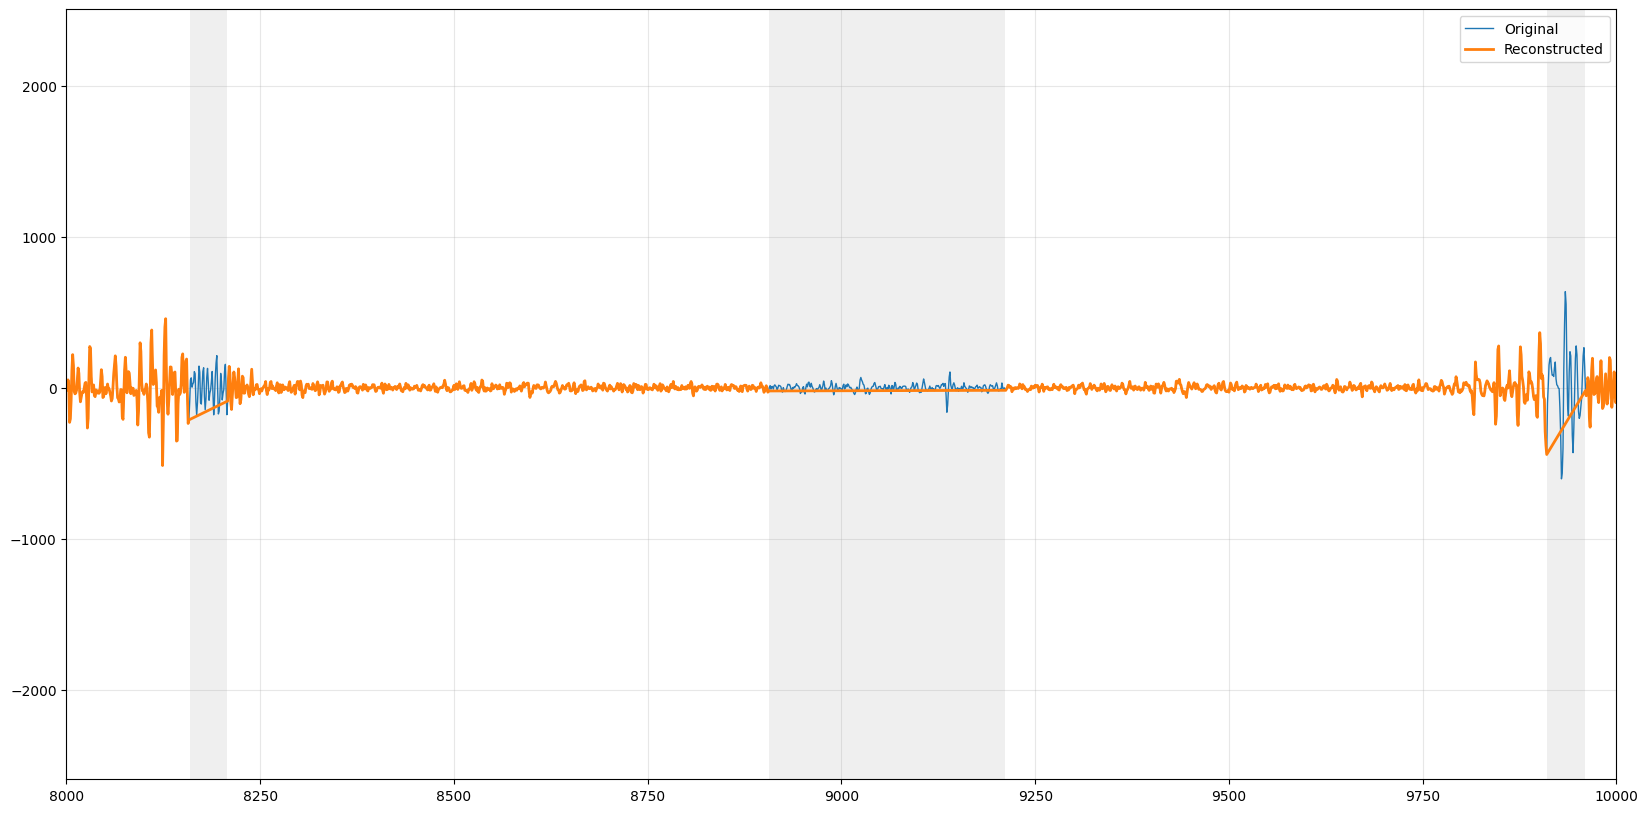

In [95]:
import numpy as np
import matplotlib.pyplot as plt

N = len(df)
data_reconstructed = []
pos_all = []

for w in feature_data:
    s = int(w["start_idx"])
    e = int(w["end_idx"])          # IMPORTANT: assume end_idx is EXCLUSIVE
    s = max(0, min(s, N))
    e = max(0, min(e, N))
    if e <= s:
        continue

    data_reconstructed.extend(df["Ch_1_filt"].iloc[s:e].to_numpy())
    pos_all.extend(np.arange(s, e))

data_reconstructed = np.asarray(data_reconstructed)
pos_all = np.asarray(pos_all)

x_df = df.index.to_numpy()
y_df = df["Ch_1_filt"].to_numpy()

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(x_df, y_df, label="Original", linewidth=1)

# plot reconstructed using df.index at those positions
ax.plot(x_df[pos_all], data_reconstructed, label="Reconstructed", linewidth=2)

present = np.zeros(N, dtype=bool)
present[pos_all] = True

missing = np.flatnonzero(~present)
if missing.size:
    cuts = np.flatnonzero(np.diff(missing) != 1) + 1
    blocks = np.split(missing, cuts)
    for b in blocks:
        ax.axvspan(x_df[b[0]], x_df[b[-1]], color="lightgrey", alpha=0.35, linewidth=0)

ax.legend()
ax.grid(True, alpha=0.3)
plt.xlim(8000, 10000)
plt.show()




# After saving

In [135]:
df_loaded = pd.read_hdf(r"C:\Users\giusy\OneDrive\Desktop\PAPERS\2026_Sensors_speech\SilentWear\data\wins_and_feats\silent\WIN_1400\sess_1_batch_1.h5")

feature_data = df_loaded.copy()
feature_data.columns

Index(['rms_1_Ch_0_filt', 'max_1_Ch_0_filt', 'min_1_Ch_0_filt',
       'std_1_Ch_0_filt', 'var_1_Ch_0_filt', 'q25_1_Ch_0_filt',
       'q75_1_Ch_0_filt', 'mean_1_Ch_0_filt', 'zcr_1_Ch_0_filt',
       'mean_f_1_Ch_0_filt',
       ...
       'Ch_4_filt', 'Ch_5_filt', 'Ch_6_filt', 'Ch_7_filt', 'Ch_8_filt',
       'Ch_9_filt', 'Ch_10_filt', 'Ch_11_filt', 'Ch_14_filt', 'Ch_15_filt'],
      dtype='object', length=2372)

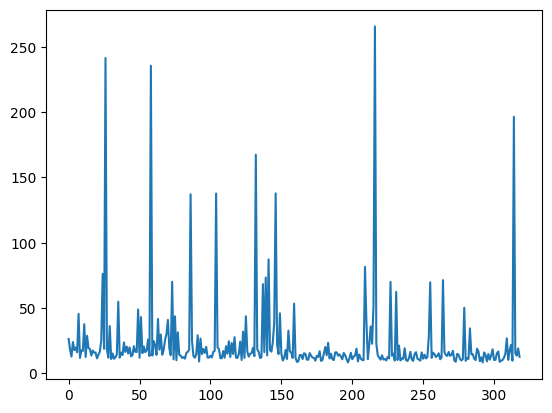

In [140]:
plt.plot(feature_data['rms_1_Ch_9_filt'])